# What's in this notebook

In our previous rounds of EDA and modeling, we have established that these models perform quite poorly for the dataset we have:
* Linear Regression
* Lasso
* Polynomial Features

Therefore, in this notebook, we will exclusively try to Grid Search various permutations of hyper-parameters for Random Forest Regressor.

Decision Tree Regressor generally does not work as well as Random Forest simply because there's only one tree. However, we will use Decision Tree to understand our top predictors.

# setting up

## imports and settings

In [1]:
import psycopg2
import sys, os
import numpy as np
import pandas as pd
import capstone_connect as creds
import pandas.io.sql as psql
import pandas_profiling

# for datetime manipulation
import datetime as dt

# for modeling
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler,  PolynomialFeatures 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn import metrics

# turning off warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# visualisations related imports and settings

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# changing our pandas settings so that we can view all columns 
pd.set_option('max_columns', 999)

# graphviz to make a chart of the regression tree decision points
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus



In [3]:
# optional installations

# !pip install pydot2
# !pip install graphviz
# !pip install pydotplus

# I had a lot of issues with graphviz on windows
# the instructions here [https://datascience.stackexchange.com/questions/37428/graphviz-not-working-when-imported-inside-pydotplus-graphvizs-executables-not]
# to install graphviz directly and set the path variable turned out the most useful.

## 2018 data - train

In [4]:
pkl_2018 = pd.read_pickle("./data/train_2018.pkl")

In [5]:
train_df = pkl_2018.copy()

print(train_df.shape)
train_df.head()

(1306, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1             0          0     3894  339.482345   
1           1             0          0     4533  282.818878   
2           1             0          0     2819  311.730205   
3           1             0          1      705  353.433962   
4           1             0          1       30  300.000000   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   0                    1   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

In [6]:
# changing `is_foreigner` to boolean to help with the Decision Tree interpretation

# value_counts before changing to boolean
print(train_df['is_foreigner'].value_counts(dropna=False))
print()

train_df['is_foreigner'] = train_df['is_foreigner'].astype(bool)

# value_counts after changing to boolean
print(train_df['is_foreigner'].value_counts(dropna=False))

train_df.head()

0    668
1    638
Name: is_foreigner, dtype: int64

False    668
True     638
Name: is_foreigner, dtype: int64


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1         False          0     3894  339.482345   
1           1         False          0     4533  282.818878   
2           1         False          0     2819  311.730205   
3           1         False          1      705  353.433962   
4           1         False          1       30  300.000000   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   0                    1   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

## 2019 data - test set

In [7]:
pkl_2019 = pd.read_pickle("./data/test_2019.pkl")

In [8]:
test_df = pkl_2019.copy()

print(test_df.shape)
test_df.head()

(1211, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1             0          0     4575  350.345572   
1           1             0          0     3102  323.768461   
2           1             0          0     2856  340.823988   
3           1             0          1      321  420.000000   
4           1             0          1      916  320.602941   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   1                    0   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

In [9]:
# changing `is_foreigner` to boolean to help with the Decision Tree interpretation

# value_counts before changing to boolean
print(test_df['is_foreigner'].value_counts(dropna=False))
print()

test_df['is_foreigner'] = test_df['is_foreigner'].astype(bool)

# value_counts after changing to boolean
print(test_df['is_foreigner'].value_counts(dropna=False))

test_df.head()

0    631
1    580
Name: is_foreigner, dtype: int64

False    631
True     580
Name: is_foreigner, dtype: int64


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1         False          0     4575  350.345572   
1           1         False          0     3102  323.768461   
2           1         False          0     2856  340.823988   
3           1         False          1      321  420.000000   
4           1         False          1      916  320.602941   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   1                    0   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

# modeling set-up


## features and target

In [10]:
train_feat = train_df.drop('sum_tix', axis=1)
print("features:", train_feat.shape)
display(train_feat.head())

train_target = train_df[['sum_tix']]
print("target:", train_target.shape)
display(train_target.head())

features: (1306, 17)


trip_month  is_foreigner  bus_class     avg_dur  depart_period_aft  \
0           1         False          0  339.482345                  1   
1           1         False          0  282.818878                  0   
2           1         False          0  311.730205                  0   
3           1         False          1  353.433962                  1   
4           1         False          1  300.000000                  0   

   depart_period_morn  depart_period_night  subroute_name_Mandalay-Naypyitaw  \
0                   0                    0                                 1   
1                   1                    0                                 1   
2                   0                    1                                 1   
3                   0                    0                                 1   
4                   0                    1                                 1   

   subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   

   subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   subroute_name_Yangon-Taunggyi  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

target: (1306, 1)


sum_tix
0     3894
1     4533
2     2819
3      705
4       30

In [11]:
test_feat = test_df.drop('sum_tix', axis=1)
print("features:", test_feat.shape)
display(test_feat.head())

test_target = test_df[['sum_tix']]
print("target:", test_target.shape)
display(test_target.head())

features: (1211, 17)


trip_month  is_foreigner  bus_class     avg_dur  depart_period_aft  \
0           1         False          0  350.345572                  1   
1           1         False          0  323.768461                  0   
2           1         False          0  340.823988                  0   
3           1         False          1  420.000000                  1   
4           1         False          1  320.602941                  0   

   depart_period_morn  depart_period_night  subroute_name_Mandalay-Naypyitaw  \
0                   0                    0                                 1   
1                   1                    0                                 1   
2                   0                    1                                 1   
3                   0                    0                                 1   
4                   1                    0                                 1   

   subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   

   subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   subroute_name_Yangon-Taunggyi  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

target: (1211, 1)


sum_tix
0     4575
1     3102
2     2856
3      321
4      916

## tracking model performance

In [12]:
# creating a scores table to keep track of our model performance
scores_table = pd.DataFrame(columns = [
                            "model", 
                            "comments",
                            "searched_params",
                            "best_params", 
                            "train_score", 
                            "train_rmse",
                            "test_score",
                            "test_rmse",
                            "dotfile_name"
                                    ])

In [13]:
scores_table.head()

Empty DataFrame
Columns: [model, comments, searched_params, best_params, train_score, train_rmse, test_score, test_rmse, dotfile_name]
Index: []

In [14]:
# this function allows us run calculations on whether the model performs better on test_score vs train_score
# this difference is calculated by test_score - train_score
# negative scores indicate the model is overfit to the train dataset
# positive scores indicate the model is underfit 
# the best scores will be displayed in green

def run_diff():
    scores_table["train_test_fit"] = scores_table["test_score"] - scores_table["train_score"]
    display(scores_table.style.highlight_max(color='lightgreen', subset=["test_score", "train_test_fit"]))

## Random Forest Regressor

### rf_params v1

In [15]:
rf_params = {
    'n_estimators': [10, 15, 20, 25],
    'max_depth': [2, 3, 4, 5],
}

In [16]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 5, 'n_estimators': 15}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=15,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9353501943462108
train rmse is: 1039.5114032548604

test_score score is: 0.8060828057687937
test rmse is: 1855.4202886121764


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.6s finished


### rf_params v2

In [17]:
rf_params = {
    'n_estimators': [15, 30, 50],
    'max_depth': [2, 3, 4, 5],
}

In [18]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 5, 'n_estimators': 30}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.93842548268215
train rmse is: 1014.4862240909281

test_score score is: 0.811160041630594
test rmse is: 1830.969415147259


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.0s finished


### rf_params v3

In [19]:
rf_params = {
    'n_estimators': [15, 30, 50],
    'max_depth': [4, 5, 6, 7],
}

In [20]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 7, 'n_estimators': 30}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9821281525365009
train rmse is: 546.5505938659878

test_score score is: 0.8562957632606193
test rmse is: 1597.2354035523795


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.5s finished


### rf_params v4

In [21]:
rf_params = {
    'n_estimators': [30, 40, 50],
    'max_depth': [5, 6, 7, 8],
}

In [22]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 7, 'n_estimators': 30}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9821281525365009
train rmse is: 546.5505938659878

test_score score is: 0.8562957632606193
test rmse is: 1597.2354035523795


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.7s finished


### rf_params v5

In [23]:
rf_params = {
    'n_estimators': [30, 50, 100],
    'max_depth': [6, 8],
}

In [24]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'max_depth': 6, 'n_estimators': 30}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9711213464014333
train rmse is: 694.7588964764954

test_score score is: 0.8595036994528163
test rmse is: 1579.3070942974066


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.6s finished


### rf_params v6

In [25]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [6, 8],
}

In [26]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.9s finished


{'max_depth': 8, 'n_estimators': 100}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9896627470483516
train rmse is: 415.66955619332623

test_score score is: 0.8608357541394287
test rmse is: 1571.8025067297158


## Decision Tree Regressor

In [27]:
# this will help us keep track of our many dot files
dot_name = 1

### dt_params v1

In [28]:
dt_params = {
    'max_depth': [2, 3, 4, 5], 
            }

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'max_depth': 2}

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
train score is: 0.35806217565560683
train rmse is: 3275.609552756993

test_score score is: 0.29325360010202217
test rmse is: 3542.141810395355


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


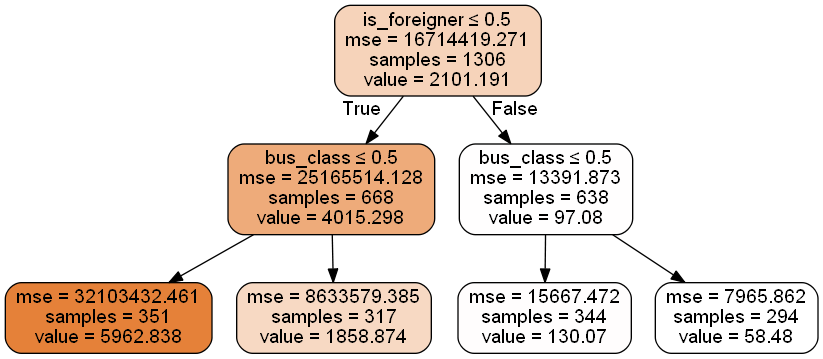

In [29]:
dt = DecisionTreeRegressor(random_state = 42)

gs = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)

dt = gs.best_estimator_

dt.fit(train_feat, train_target)

train_score = dt.score(train_feat, train_target)
test_score = dt.score(test_feat, test_target)

train_pred = dt.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = dt.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

file_name = "dt_" + str(dot_name) 
file_path = "./tree_diagrams/" + file_name + ".dot"
dot_name = dot_name + 1

scores_table = scores_table.append( { 
        "model": "Decision Tree Regressor", 
        "searched_params": dt_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": file_name
                                }, ignore_index=True )
run_diff()

print()

dotfile = open(file_path, "w")
tree.export_graphviz(dt, out_file = dotfile, feature_names=train_feat.columns)
dotfile.close()


dot_data = StringIO()  

tree.export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=train_feat.columns )  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png("./tree_diagrams/" + file_name + ".png")

Image(graph.create_png())  

### dt_params v2

In [30]:
dt_params = {
    'max_depth': [4, 5, 6, 7, 8], 
            }

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


{'max_depth': 6}

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
train score is: 0.9657008080651134
train rmse is: 757.1598739116602

test_score score is: 0.8279544530418915
test rmse is: 1747.6556283326775


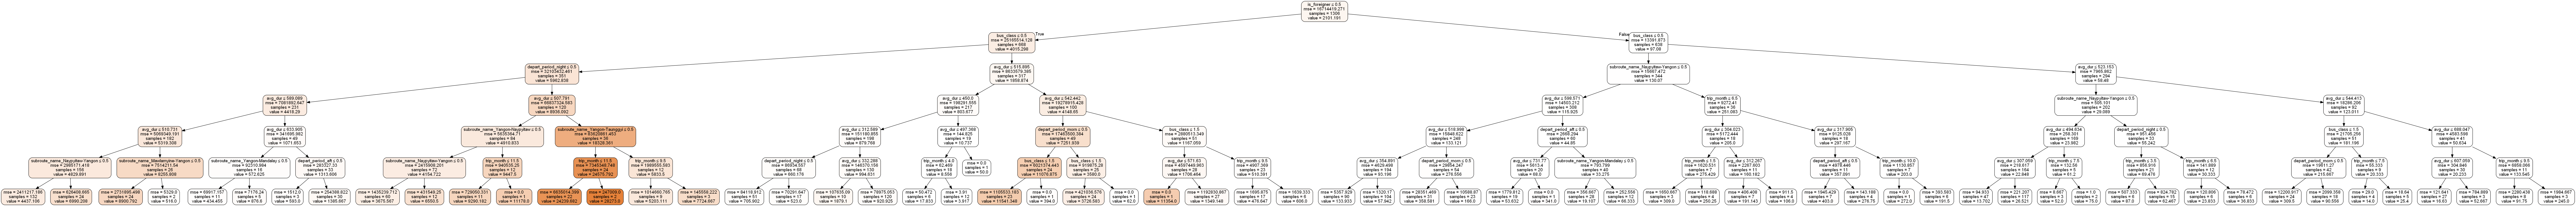

In [31]:
dt = DecisionTreeRegressor(random_state = 42)

gs = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)

dt = gs.best_estimator_

dt.fit(train_feat, train_target)

train_score = dt.score(train_feat, train_target)
test_score = dt.score(test_feat, test_target)

train_pred = dt.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = dt.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

file_name = "dt_" + str(dot_name) 
file_path = "./tree_diagrams/" + file_name + ".dot"
dot_name = dot_name + 1

scores_table = scores_table.append( { 
        "model": "Decision Tree Regressor", 
        "searched_params": dt_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": file_name
                                }, ignore_index=True )
run_diff()

print()

dotfile = open(file_path, "w")
tree.export_graphviz(dt, out_file = dotfile, feature_names=train_feat.columns)
dotfile.close()


dot_data = StringIO()  

tree.export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=train_feat.columns )  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png("./tree_diagrams/" + file_name + ".png")

Image(graph.create_png())  

## Observations

max_depth = 6 seems to be the optimum number for good test_scores for both Random Forest and Decision Tree regresors.

From the tables, we can see that increasing max_depth to 7 doesn't give us significantly higher gains. 

In addition, the upper bound on our max_depth options for GridSearchCV is 8 - because any deeper than that and we risk over-fitting. 

From the decision trees, we can also observe that 

# analysing RMSE

RMSE  has generally been about 1,500 to 1,800 which sounds quite high. So let's take a look at the distribution of the no of tickets to see if the RMSE is reasonable.

Text(0.5, 1.0, 'boxplot of no. of tickets sold')

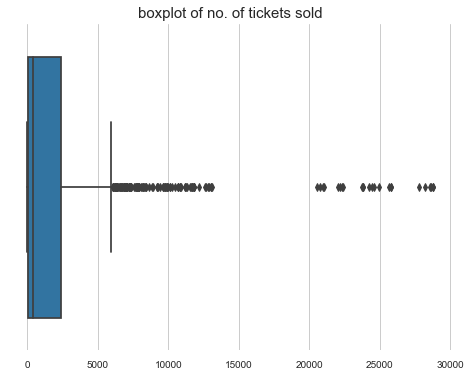

In [32]:
plt.figure(figsize=(8,6))
sns.boxplot(train_target)
plt.title("boxplot of no. of tickets sold", fontsize=15)


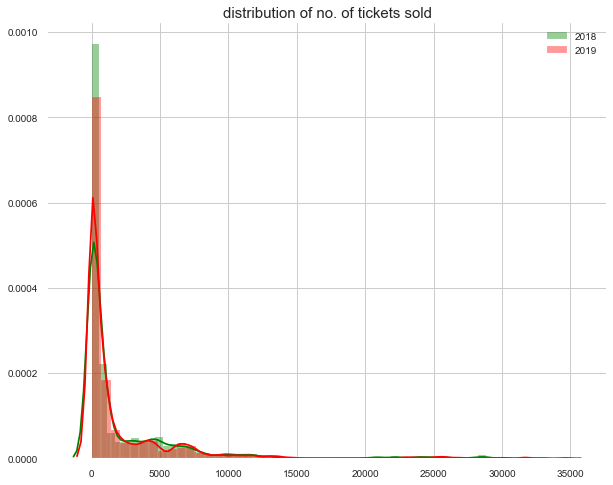

In [33]:
plt.figure(figsize=(10,8))
sns.distplot(train_target, label='2018', color='green')
sns.distplot(test_target, label='2019', color='red')
plt.title("distribution of no. of tickets sold", fontsize=15)
plt.legend()

Text(0.5, 1.0, 'distribution of no. of tickets sold (xlim = 5,000)')

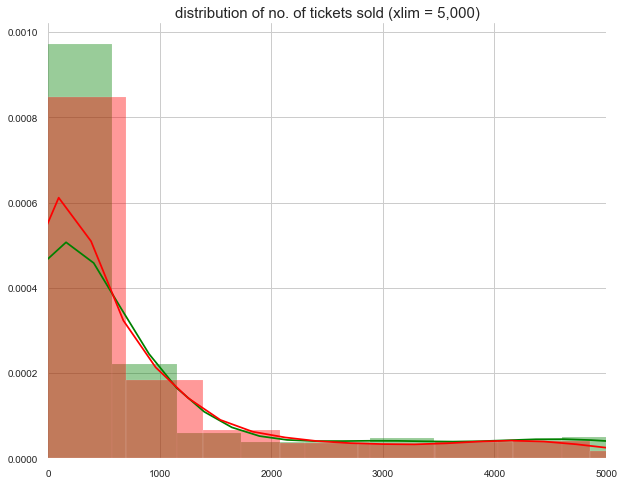

In [34]:
plt.figure(figsize=(10,8))
sns.distplot(train_target, label='2018', color='green')
sns.distplot(test_target, label='2019', color='red')

plt.xlim(0,5000)
plt.title("distribution of no. of tickets sold (xlim = 5,000)", fontsize=15)


In [35]:
# finding out the proprotion of rows with sum_tix <= 5,000
print("2018:", sum(train_target.sum_tix<=5000) / len(train_target))
print("2019:", sum(test_target.sum_tix<=5000) / len(test_target))


2018: 0.8575803981623277
2019: 0.870355078447564


In [36]:
# finding out the number of rows with sum_tix <= 3,000
print("2018:", sum(train_target.sum_tix<=3000) / len(train_target))
print("2019:", sum(test_target.sum_tix<=3000) / len(test_target))


2018: 0.7718223583460949
2019: 0.7952105697770437


In [37]:
train_target.describe()

sum_tix
count   1306.000000
mean    2101.191424
std     4089.893306
min        1.000000
25%       47.250000
50%      356.500000
75%     2411.000000
max    28797.000000

The distribution of ticket sales is pretty similar for both 2018 and 2019.

For the train dataset (i.e. 2018 dataset) the median number of seats is 356 and mean is around 2000. RMSE of 1,500 is pretty overwhelming in this context!

# model v2: bucketing on sum_tix

Let's try again to see if segmenting the customers into two buckets helps:
* sum_tix <= 5000
* sum_tix > 5000

In [38]:
train_u5 = train_df[train_df['sum_tix'] <= 5000]

print(train_u5.shape)

train_u5.head()

(1120, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1         False          0     3894  339.482345   
1           1         False          0     4533  282.818878   
2           1         False          0     2819  311.730205   
3           1         False          1      705  353.433962   
4           1         False          1       30  300.000000   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   0                    1   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

In [39]:
test_u5 = test_df[test_df['sum_tix'] <= 5000]

print(test_u5.shape)

test_u5.head()

(1054, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1         False          0     4575  350.345572   
1           1         False          0     3102  323.768461   
2           1         False          0     2856  340.823988   
3           1         False          1      321  420.000000   
4           1         False          1      916  320.602941   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   1                    0   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

## features and target

In [40]:
train_feat = train_u5.drop('sum_tix', axis=1)
print("features:", train_feat.shape)
display(train_feat.head())

train_target = train_u5[['sum_tix']]
print("target:", train_target.shape)
display(train_target.head())

features: (1120, 17)


trip_month  is_foreigner  bus_class     avg_dur  depart_period_aft  \
0           1         False          0  339.482345                  1   
1           1         False          0  282.818878                  0   
2           1         False          0  311.730205                  0   
3           1         False          1  353.433962                  1   
4           1         False          1  300.000000                  0   

   depart_period_morn  depart_period_night  subroute_name_Mandalay-Naypyitaw  \
0                   0                    0                                 1   
1                   1                    0                                 1   
2                   0                    1                                 1   
3                   0                    0                                 1   
4                   0                    1                                 1   

   subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   

   subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   subroute_name_Yangon-Taunggyi  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

target: (1120, 1)


sum_tix
0     3894
1     4533
2     2819
3      705
4       30

In [41]:
test_feat = test_u5.drop('sum_tix', axis=1)
print("features:", test_feat.shape)
display(test_feat.head())

test_target = test_u5[['sum_tix']]
print("target:", test_target.shape)
display(test_target.head())

features: (1054, 17)


trip_month  is_foreigner  bus_class     avg_dur  depart_period_aft  \
0           1         False          0  350.345572                  1   
1           1         False          0  323.768461                  0   
2           1         False          0  340.823988                  0   
3           1         False          1  420.000000                  1   
4           1         False          1  320.602941                  0   

   depart_period_morn  depart_period_night  subroute_name_Mandalay-Naypyitaw  \
0                   0                    0                                 1   
1                   1                    0                                 1   
2                   0                    1                                 1   
3                   0                    0                                 1   
4                   1                    0                                 1   

   subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   

   subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   subroute_name_Yangon-Taunggyi  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

target: (1054, 1)


sum_tix
0     4575
1     3102
2     2856
3      321
4      916

## Random Forest Regressor

In [42]:
# since GridSearchCV on these hyperparameters gave us our best results, we'll use them

rf_parms = {
    'n_estimators': [50, 100], 
    'max_depth': [6, 8]
}

In [43]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "comments": "when sum_tix <= 5000",
        "searched_params": rf_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.8s finished


{'max_depth': 6, 'n_estimators': 50}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9595293019760791
train rmse is: 252.34306461794824

test_score score is: 0.6423226682097527
test rmse is: 712.6537852036303


## Decision Tree Regressor

In [44]:
# since GridSearchCV on these hyperparameters gave us our best results, we'll use them
dt_params = {'max_depth': [4, 5, 6, 7, 8]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


{'max_depth': 5}

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
train score is: 0.9067393857290741
train rmse is: 383.0629610709436

test_score score is: 0.6198403184054191
test rmse is: 734.7099395536977


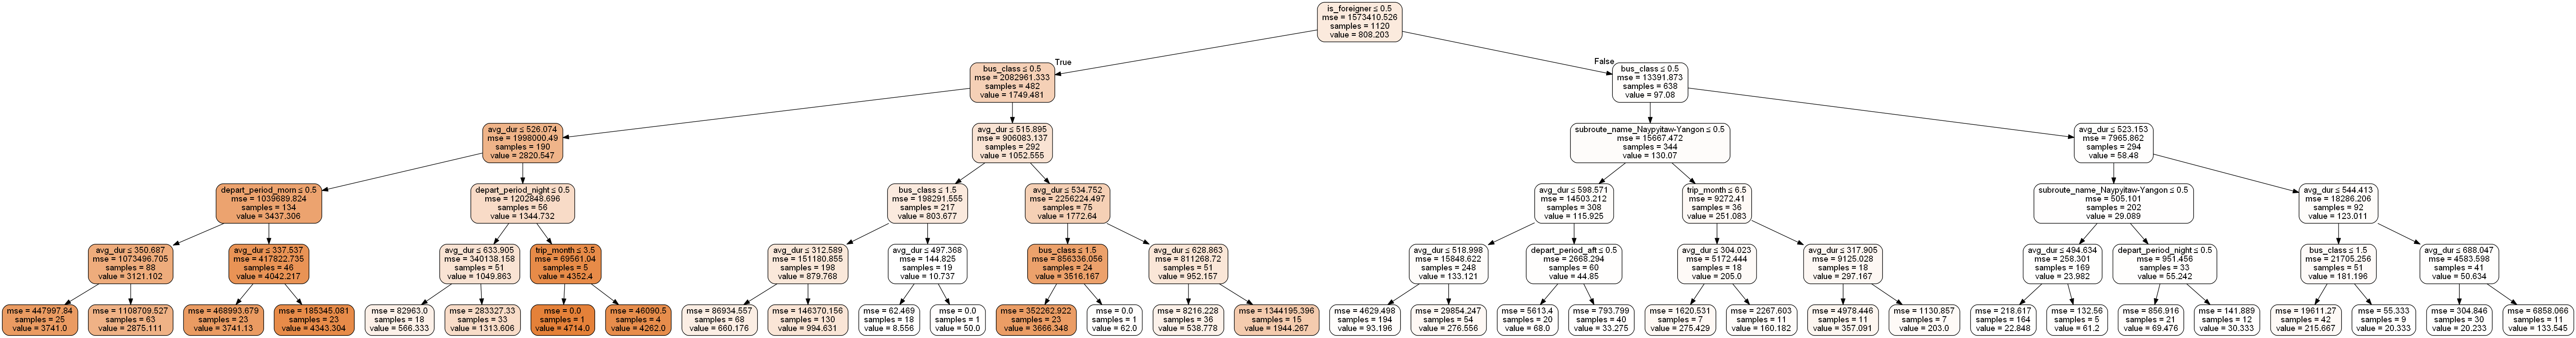

In [45]:
dt = DecisionTreeRegressor(random_state = 42)

gs = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)

dt = gs.best_estimator_

dt.fit(train_feat, train_target)

train_score = dt.score(train_feat, train_target)
test_score = dt.score(test_feat, test_target)

train_pred = dt.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = dt.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

file_name = "dt_" + str(dot_name) 
file_path = "./tree_diagrams/" + file_name + ".dot"
dot_name = dot_name + 1

scores_table = scores_table.append( { 
        "model": "Decision Tree Regressor", 
        "comments": "when sum_tix <= 5000",
        "searched_params": dt_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": file_name
                                }, ignore_index=True )
run_diff()

print()

dotfile = open(file_path, "w")
tree.export_graphviz(dt, out_file = dotfile, feature_names=train_feat.columns)
dotfile.close()


dot_data = StringIO()  

tree.export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=train_feat.columns )  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png("./tree_diagrams/" + file_name + ".png")

Image(graph.create_png())  

Neither of the v2 models worked very well. RMSE may have dropped significantly, but so did the test scores.

# model v3: separting on is_foreigner

We have observed across Decision Tree models that typically, the biggest predictor `is_foreigner` so what if we created two sets of model based on the predictor's boolean values?

In [46]:
print("train:", train_df['is_foreigner'].value_counts(dropna=False))
print("test:", test_df['is_foreigner'].value_counts(dropna=False))


train: False    668
True     638
Name: is_foreigner, dtype: int64
test: False    631
True     580
Name: is_foreigner, dtype: int64


The distribution seems similar enough..

## when `is_foreigner` = 0

In [47]:
print(train_df[train_df['is_foreigner'] == 0].shape)

train_df[train_df['is_foreigner'] == 0]

(668, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0              1         False          0     3894  339.482345   
1              1         False          0     4533  282.818878   
2              1         False          0     2819  311.730205   
3              1         False          1      705  353.433962   
4              1         False          1       30  300.000000   
...          ...           ...        ...      ...         ...   
1296          12         False          0      899  750.000000   
1297          12         False          0      611  720.000000   
1298          12         False          0     7878  661.120421   
1299          12         False          1      651  600.000000   
1300          12         False          1     4274  697.856258   

      depart_period_aft  depart_period_morn  depart_period_night  \
0                     1                   0                    0   
1                     0                   1                    0   
2                     0                   0                    1   
3                     1                   0                    0   
4                     0                   0                    1   
...                 ...                 ...                  ...   
1296                  1                   0                    0   
1297                  0                   1                    0   
1298                  0                   0                    1   
1299                  0                   1                    0   
1300                  0                   0                    1   

      subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                    1                              0   
1                                    1                              0   
2                                    1                              0   
3                                    1                              0   
4                                    1                              0   
...                                ...                            ...   
1296                                 0                              0   
1297                                 0                              0   
1298                                 0                              0   
1299                                 0                              0   
1300                                 0                              0   

      subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                   0                                 0   
1                                   0                                 0   
2                                   0                                 0   
3                                   0                                 0   
4                                   0                                 0   
...                               ...                               ...   
1296                                0                                 0   
1297                                0                                 0   
1298                                0                                 0   
1299                                0                                 0   
1300                                0                                 0   

      subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                                  0                              0   
1                                  0                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              0   
...                              ...                            ...   
1296                               0                              0   
1297                               0              

In [48]:
train_local = train_df[train_df['is_foreigner'] == 0]
train_local.head()

trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1         False          0     3894  339.482345   
1           1         False          0     4533  282.818878   
2           1         False          0     2819  311.730205   
3           1         False          1      705  353.433962   
4           1         False          1       30  300.000000   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   0                    1   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

In [49]:
print(test_df[test_df['is_foreigner'] == 0].shape)

test_df[test_df['is_foreigner'] == 0].head()

(631, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1         False          0     4575  350.345572   
1           1         False          0     3102  323.768461   
2           1         False          0     2856  340.823988   
3           1         False          1      321  420.000000   
4           1         False          1      916  320.602941   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   1                    0   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

In [50]:
test_local = test_df[test_df['is_foreigner'] == 0]
test_local.head()

trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
0           1         False          0     4575  350.345572   
1           1         False          0     3102  323.768461   
2           1         False          0     2856  340.823988   
3           1         False          1      321  420.000000   
4           1         False          1      916  320.602941   

   depart_period_aft  depart_period_morn  depart_period_night  \
0                  1                   0                    0   
1                  0                   1                    0   
2                  0                   0                    1   
3                  1                   0                    0   
4                  0                   1                    0   

   subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
0                                 1                              0   
1                                 1                              0   
2                                 1                              0   
3                                 1                              0   
4                                 1                              0   

   subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   

   subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
0                          0                              0  
1                          0                              0  
2                          0                              0  
3                          0                              0  
4                          0                              0

In [51]:
# we need to drop the `is_foreigner` column

train_local.drop('is_foreigner', axis=1, inplace=True)
print("train:", train_local.shape)

test_local.drop('is_foreigner', axis=1, inplace=True)
print("test", test_local.shape)

train: (668, 17)
test (631, 17)


### features and target

In [52]:
train_feat = train_local.drop('sum_tix', axis=1)
print("features:", train_feat.shape)
display(train_feat.head())

train_target = train_local[['sum_tix']]
print("target:", train_target.shape)
display(train_target.head())

features: (668, 16)


trip_month  bus_class     avg_dur  depart_period_aft  depart_period_morn  \
0           1          0  339.482345                  1                   0   
1           1          0  282.818878                  0                   1   
2           1          0  311.730205                  0                   0   
3           1          1  353.433962                  1                   0   
4           1          1  300.000000                  0                   0   

   depart_period_night  subroute_name_Mandalay-Naypyitaw  \
0                    0                                 1   
1                    0                                 1   
2                    1                                 1   
3                    0                                 1   
4                    1                                 1   

   subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   

   subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   subroute_name_Yangon-Taunggyi  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

target: (668, 1)


sum_tix
0     3894
1     4533
2     2819
3      705
4       30

In [53]:
test_feat = test_local.drop('sum_tix', axis=1)
print("features:", test_feat.shape)
display(test_feat.head())

test_target = test_local[['sum_tix']]
print("target:", test_target.shape)
display(test_target.head())

features: (631, 16)


trip_month  bus_class     avg_dur  depart_period_aft  depart_period_morn  \
0           1          0  350.345572                  1                   0   
1           1          0  323.768461                  0                   1   
2           1          0  340.823988                  0                   0   
3           1          1  420.000000                  1                   0   
4           1          1  320.602941                  0                   1   

   depart_period_night  subroute_name_Mandalay-Naypyitaw  \
0                    0                                 1   
1                    0                                 1   
2                    1                                 1   
3                    0                                 1   
4                    0                                 1   

   subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   

   subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   subroute_name_Yangon-Taunggyi  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

target: (631, 1)


sum_tix
0     4575
1     3102
2     2856
3      321
4      916

### Random Forest Regressor

In [54]:
# since GridSearchCV on these hyperparameters gave us our best results, we'll use them

rf_parms = {
    'n_estimators': [50, 100], 
    'max_depth': [6, 8]
}

In [55]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_params,
        "comments": "when is_foreigner = False",
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.5s finished


{'max_depth': 6, 'n_estimators': 100}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9789661057975986
train rmse is: 727.5498345296359

test_score score is: 0.8279584585555887
test rmse is: 2184.118097056651


### Decision Tree Regressor

In [56]:
# since GridSearchCV on these hyperparameters gave us our best results, we'll use them
dt_params = {'max_depth': [4, 5, 6, 7, 8]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


{'max_depth': 4}

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
train score is: 0.9179938253707964
train rmse is: 1436.5679748068358

test_score score is: 0.7355933826632494
test rmse is: 2707.6692623224703


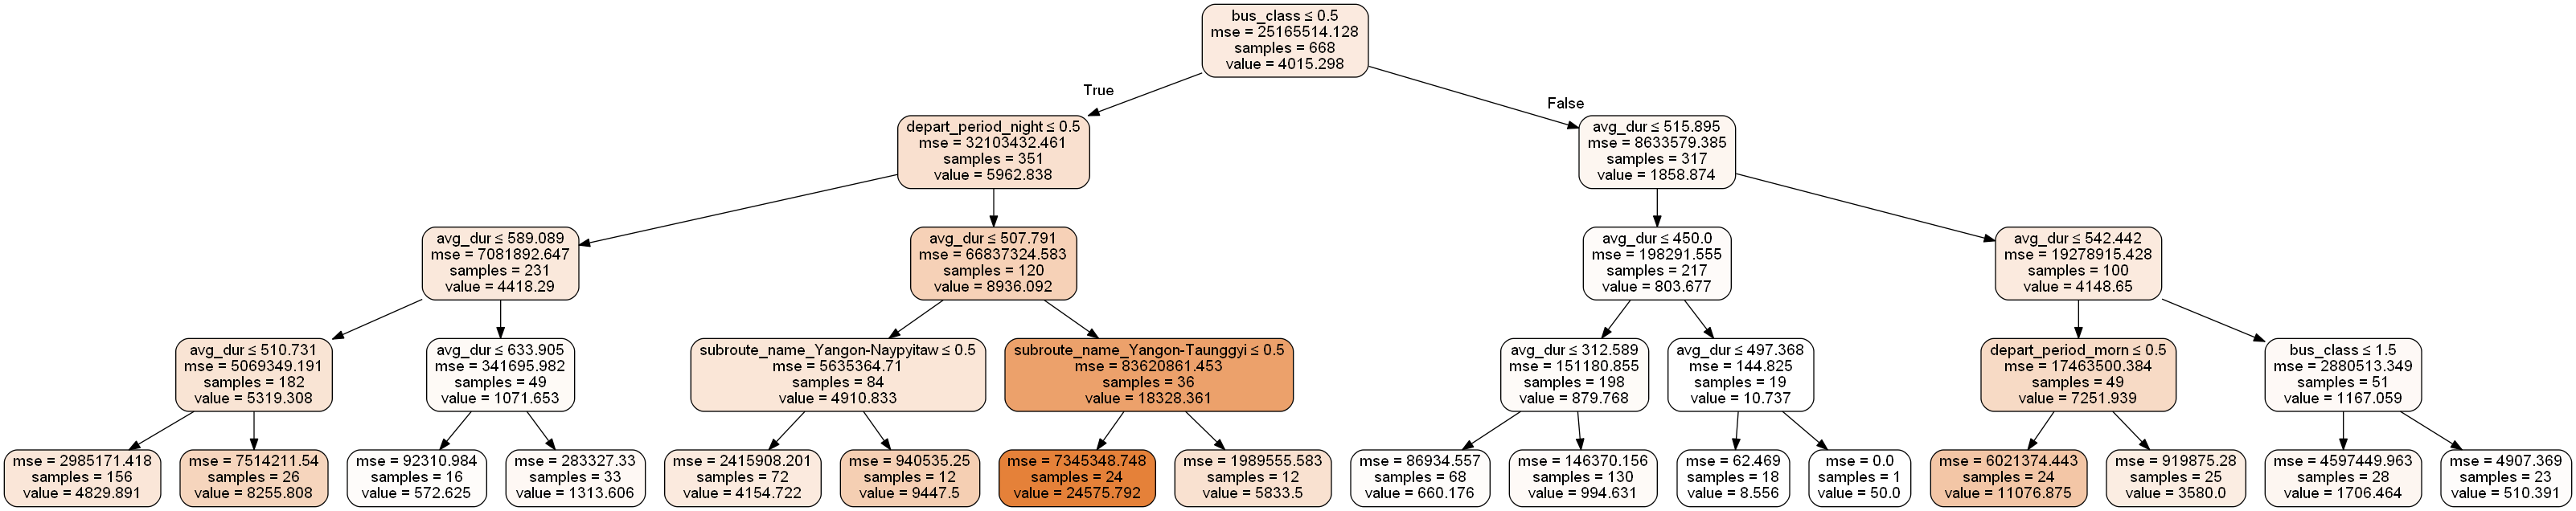

In [57]:
dt = DecisionTreeRegressor(random_state = 42)

gs = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)

dt = gs.best_estimator_

dt.fit(train_feat, train_target)

train_score = dt.score(train_feat, train_target)
test_score = dt.score(test_feat, test_target)

train_pred = dt.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = dt.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

file_name = "dt_" + str(dot_name) 
file_path = "./tree_diagrams/" + file_name + ".dot"
dot_name = dot_name + 1

scores_table = scores_table.append( { 
        "model": "Decision Tree Regressor", 
        "comments": "when is_foreigner = False",
        "searched_params": dt_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": file_name
                                }, ignore_index=True )
run_diff()

print()

dotfile = open(file_path, "w")
tree.export_graphviz(dt, out_file = dotfile, feature_names=train_feat.columns)
dotfile.close()


dot_data = StringIO()  

tree.export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=train_feat.columns )  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png("./tree_diagrams/" + file_name + ".png")

Image(graph.create_png())  

## when `is_foreigner` = 1

In [58]:
print(train_df[train_df['is_foreigner'] == 1].shape)

train_df[train_df['is_foreigner'] == 1]

(638, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
5              1          True          0      158  316.229508   
6              1          True          0      137  288.837209   
7              1          True          0       69  315.000000   
8              1          True          1       39  340.000000   
14             2          True          0      149  332.432432   
...          ...           ...        ...      ...         ...   
1301          12          True          0       70  750.000000   
1302          12          True          0        1  720.000000   
1303          12          True          0       86  674.634146   
1304          12          True          1       38  600.000000   
1305          12          True          1      277  707.054795   

      depart_period_aft  depart_period_morn  depart_period_night  \
5                     1                   0                    0   
6                     0                   1                    0   
7                     0                   0                    1   
8                     1                   0                    0   
14                    1                   0                    0   
...                 ...                 ...                  ...   
1301                  1                   0                    0   
1302                  0                   1                    0   
1303                  0                   0                    1   
1304                  0                   1                    0   
1305                  0                   0                    1   

      subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
5                                    1                              0   
6                                    1                              0   
7                                    1                              0   
8                                    1                              0   
14                                   1                              0   
...                                ...                            ...   
1301                                 0                              0   
1302                                 0                              0   
1303                                 0                              0   
1304                                 0                              0   
1305                                 0                              0   

      subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
5                                   0                                 0   
6                                   0                                 0   
7                                   0                                 0   
8                                   0                                 0   
14                                  0                                 0   
...                               ...                               ...   
1301                                0                                 0   
1302                                0                                 0   
1303                                0                                 0   
1304                                0                                 0   
1305                                0                                 0   

      subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
5                                  0                              0   
6                                  0                              0   
7                                  0                              0   
8                                  0                              0   
14                                 0                              0   
...                              ...                            ...   
1301                               0                              0   
1302                               0              

In [59]:
train_for = train_df[train_df['is_foreigner'] == 1]
train_for.head()

trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
5            1          True          0      158  316.229508   
6            1          True          0      137  288.837209   
7            1          True          0       69  315.000000   
8            1          True          1       39  340.000000   
14           2          True          0      149  332.432432   

    depart_period_aft  depart_period_morn  depart_period_night  \
5                   1                   0                    0   
6                   0                   1                    0   
7                   0                   0                    1   
8                   1                   0                    0   
14                  1                   0                    0   

    subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
5                                  1                              0   
6                                  1                              0   
7                                  1                              0   
8                                  1                              0   
14                                 1                              0   

    subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
5                                 0                                 0   
6                                 0                                 0   
7                                 0                                 0   
8                                 0                                 0   
14                                0                                 0   

    subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
5                                0                              0   
6                                0                              0   
7                                0                              0   
8                                0                              0   
14                               0                              0   

    subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
5                                 0                               0   
6                                 0                               0   
7                                 0                               0   
8                                 0                               0   
14                                0                               0   

    subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
5                           0                              0  
6                           0                              0  
7                           0                              0  
8                           0                              0  
14                          0                              0

In [60]:
print(test_df[test_df['is_foreigner'] == 1].shape)

test_df[test_df['is_foreigner'] == 1].head()

(580, 18)


trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
6            1          True          0      158  360.991736   
7            1          True          0       83  328.095238   
8            1          True          0       96  325.384615   
9            1          True          1       15  420.000000   
10           1          True          1       32  321.000000   

    depart_period_aft  depart_period_morn  depart_period_night  \
6                   1                   0                    0   
7                   0                   1                    0   
8                   0                   0                    1   
9                   1                   0                    0   
10                  0                   1                    0   

    subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
6                                  1                              0   
7                                  1                              0   
8                                  1                              0   
9                                  1                              0   
10                                 1                              0   

    subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
6                                 0                                 0   
7                                 0                                 0   
8                                 0                                 0   
9                                 0                                 0   
10                                0                                 0   

    subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
6                                0                              0   
7                                0                              0   
8                                0                              0   
9                                0                              0   
10                               0                              0   

    subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
6                                 0                               0   
7                                 0                               0   
8                                 0                               0   
9                                 0                               0   
10                                0                               0   

    subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
6                           0                              0  
7                           0                              0  
8                           0                              0  
9                           0                              0  
10                          0                              0

In [61]:
test_for = test_df[test_df['is_foreigner'] == 1]
test_for.head()

trip_month  is_foreigner  bus_class  sum_tix     avg_dur  \
6            1          True          0      158  360.991736   
7            1          True          0       83  328.095238   
8            1          True          0       96  325.384615   
9            1          True          1       15  420.000000   
10           1          True          1       32  321.000000   

    depart_period_aft  depart_period_morn  depart_period_night  \
6                   1                   0                    0   
7                   0                   1                    0   
8                   0                   0                    1   
9                   1                   0                    0   
10                  0                   1                    0   

    subroute_name_Mandalay-Naypyitaw  subroute_name_Mandalay-Yangon  \
6                                  1                              0   
7                                  1                              0   
8                                  1                              0   
9                                  1                              0   
10                                 1                              0   

    subroute_name_Mawlamyine-Yangon  subroute_name_Naypyitaw-Mandalay  \
6                                 0                                 0   
7                                 0                                 0   
8                                 0                                 0   
9                                 0                                 0   
10                                0                                 0   

    subroute_name_Naypyitaw-Yangon  subroute_name_Yangon-Mandalay  \
6                                0                              0   
7                                0                              0   
8                                0                              0   
9                                0                              0   
10                               0                              0   

    subroute_name_Yangon-Mawlamyine  subroute_name_Yangon-Naypyitaw  \
6                                 0                               0   
7                                 0                               0   
8                                 0                               0   
9                                 0                               0   
10                                0                               0   

    subroute_name_Yangon-Pyay  subroute_name_Yangon-Taunggyi  
6                           0                              0  
7                           0                              0  
8                           0                              0  
9                           0                              0  
10                          0                              0

In [62]:
# we need to drop the `is_foreigner` column

train_for.drop('is_foreigner', axis=1, inplace=True)
print("train:", train_for.shape)

test_for.drop('is_foreigner', axis=1, inplace=True)
print("test", test_for.shape)

train: (638, 17)
test (580, 17)


### features and target

In [63]:
train_feat = train_for.drop('sum_tix', axis=1)
print("features:", train_feat.shape)
display(train_feat.head())

train_target = train_for[['sum_tix']]
print("target:", train_target.shape)
display(train_target.head())

features: (638, 16)


trip_month  bus_class     avg_dur  depart_period_aft  depart_period_morn  \
5            1          0  316.229508                  1                   0   
6            1          0  288.837209                  0                   1   
7            1          0  315.000000                  0                   0   
8            1          1  340.000000                  1                   0   
14           2          0  332.432432                  1                   0   

    depart_period_night  subroute_name_Mandalay-Naypyitaw  \
5                     0                                 1   
6                     0                                 1   
7                     1                                 1   
8                     0                                 1   
14                    0                                 1   

    subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
5                               0                                0   
6                               0                                0   
7                               0                                0   
8                               0                                0   
14                              0                                0   

    subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
5                                  0                               0   
6                                  0                               0   
7                                  0                               0   
8                                  0                               0   
14                                 0                               0   

    subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
5                               0                                0   
6                               0                                0   
7                               0                                0   
8                               0                                0   
14                              0                                0   

    subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
5                                0                          0   
6                                0                          0   
7                                0                          0   
8                                0                          0   
14                               0                          0   

    subroute_name_Yangon-Taunggyi  
5                               0  
6                               0  
7                               0  
8                               0  
14                              0

target: (638, 1)


sum_tix
5       158
6       137
7        69
8        39
14      149

In [64]:
test_feat = test_for.drop('sum_tix', axis=1)
print("features:", test_feat.shape)
display(test_feat.head())

test_target = test_for[['sum_tix']]
print("target:", test_target.shape)
display(test_target.head())

features: (580, 16)


trip_month  bus_class     avg_dur  depart_period_aft  depart_period_morn  \
6            1          0  360.991736                  1                   0   
7            1          0  328.095238                  0                   1   
8            1          0  325.384615                  0                   0   
9            1          1  420.000000                  1                   0   
10           1          1  321.000000                  0                   1   

    depart_period_night  subroute_name_Mandalay-Naypyitaw  \
6                     0                                 1   
7                     0                                 1   
8                     1                                 1   
9                     0                                 1   
10                    0                                 1   

    subroute_name_Mandalay-Yangon  subroute_name_Mawlamyine-Yangon  \
6                               0                                0   
7                               0                                0   
8                               0                                0   
9                               0                                0   
10                              0                                0   

    subroute_name_Naypyitaw-Mandalay  subroute_name_Naypyitaw-Yangon  \
6                                  0                               0   
7                                  0                               0   
8                                  0                               0   
9                                  0                               0   
10                                 0                               0   

    subroute_name_Yangon-Mandalay  subroute_name_Yangon-Mawlamyine  \
6                               0                                0   
7                               0                                0   
8                               0                                0   
9                               0                                0   
10                              0                                0   

    subroute_name_Yangon-Naypyitaw  subroute_name_Yangon-Pyay  \
6                                0                          0   
7                                0                          0   
8                                0                          0   
9                                0                          0   
10                               0                          0   

    subroute_name_Yangon-Taunggyi  
6                               0  
7                               0  
8                               0  
9                               0  
10                              0

target: (580, 1)


sum_tix
6       158
7        83
8        96
9        15
10       32

### Random Forest Regressor

In [65]:
# since GridSearchCV on these hyperparameters gave us our best results, we'll use them

rf_parms = {
    'n_estimators': [50, 100], 
    'max_depth': [6, 8]
}

In [66]:
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)


rf = gs.best_estimator_

rf.fit(train_feat, train_target)

train_score = rf.score(train_feat, train_target)
test_score = rf.score(test_feat, test_target)

train_pred = rf.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "searched_params": rf_parms,
        "comments": "when is_foreigner = True",
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": None
                                }, ignore_index=True )
run_diff()


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.4s finished


{'max_depth': 8, 'n_estimators': 100}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
train score is: 0.9475454205899189
train rmse is: 26.50405745449896

test_score score is: 0.4233272196931446
test rmse is: 174.534849642099


### Decision Tree Regressor

In [67]:
# since GridSearchCV on these hyperparameters gave us our best results, we'll use them
dt_params = {'max_depth': [4, 5, 6, 7, 8]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 8}

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
train score is: 0.9425467665109093
train rmse is: 27.738175890825584

test_score score is: 0.35012416102753435
test rmse is: 185.28174207475647


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


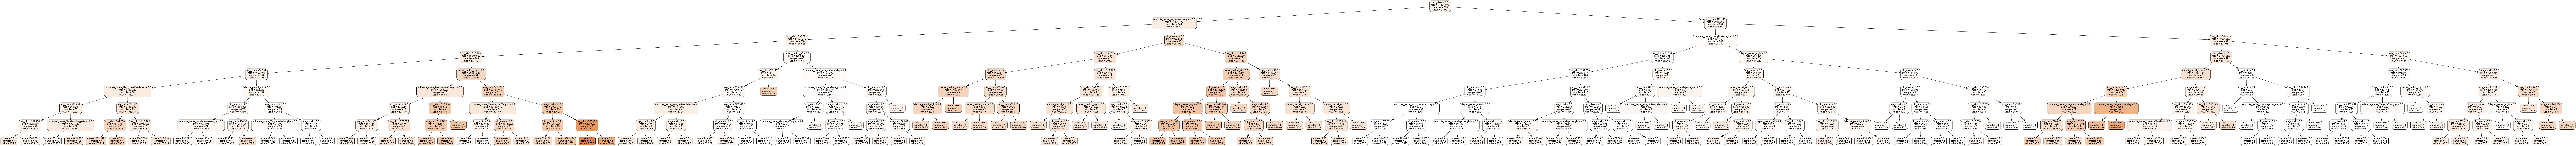

In [68]:
dt = DecisionTreeRegressor(random_state = 42)

gs = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_params_)

print()
print(gs.best_estimator_)

dt = gs.best_estimator_

dt.fit(train_feat, train_target)

train_score = dt.score(train_feat, train_target)
test_score = dt.score(test_feat, test_target)

train_pred = dt.predict(train_feat)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = dt.predict(test_feat)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

file_name = "dt_" + str(dot_name) 
file_path = "./tree_diagrams/" + file_name + ".dot"
dot_name = dot_name + 1

scores_table = scores_table.append( { 
        "model": "Decision Tree Regressor", 
        "comments": "when is_foreigner = True",
        "searched_params": dt_params,
        "best_params": gs.best_params_, 
        "train_score": train_score,
        "train_rmse": train_rmse,
        "test_score": test_score,
        "test_rmse": test_rmse,
        "dotfile_name": file_name
                                }, ignore_index=True )
run_diff()

print()

dotfile = open(file_path, "w")
tree.export_graphviz(dt, out_file = dotfile, feature_names=train_feat.columns)
dotfile.close()


dot_data = StringIO()  

tree.export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=train_feat.columns )  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png("./tree_diagrams/" + file_name + ".png")

Image(graph.create_png())  